# Orbit Raising Problem

For a solution to the orbit raising problem using a Python script instead of a notebook, see the corresponding [Python script documentation](../scripts/orbit_raising.rst).

One of the interesting things about this problem is that the dynamics are time-varying
because the dynamics of the four states depends on the mass of the vehicle, which
decreases linearly with time. One of the consequences of this is that the Hamiltonian is
not constant along the trajectory, as can be seen in the [plot of the Hamiltonian](#hamiltonian).

## Description

This problem is described by Bryson and Ho <cite data-footcite="Bryson:1975" />. For a space vehicle  with a constant-thrust rocket engine, with thrust $T$ operating continuously from time $t=0$ until time $t=t_f$, find the thrust-direction history, $\phi(t)$, to transfer a spacecraft from a given initial circular orbit to the largest possible circular orbit. A numerical solution to this problem was first found by Moyer and Pinkham <cite data-footcite="Moyer:1964"/>, who considered the problem of an orbital transfer from Earth's orbit to Mars' orbit.

The states of the system are
$$
\begin{aligned}
   r &= \text{radial distance of spacecraft from attracting center} \\
   \theta &= \text{polar angle of spacecraft} \\
   v_r &= \text{radial component of velocity} \\
   v_t &= \text{tangential component of velocity}
\end{aligned}
$$
In Bryson and Ho's formulation, the control input is the thrust direction angle $\phi$, where the angle is measured from the tangential direction. We instead describe the thrust direction in terms of its radial and tangential components, $u_r$ and $u_t$, where
$$
    u_r^2 + u_t^2 = 1
$$
Then the thrust direction angle is
$$
    \phi = \arctan \frac{u_r}{u_t}
$$
With these definitions, the equations of motion are
$$
\begin{aligned}
   \dot{r} &= v_r \\
   \dot{\theta} &= \frac{v_t}{r} \\
   \dot{v_r} &= \frac{v_t^{2}}{r}-\frac{\mu}{r^{2}}+\frac{T}{m_{0}-|\dot{m}|t} u_r \\
   \dot{v_t} &= -\frac{v_r v_t}{r}+\frac{T}{m_{0}-|\dot{m}|t} u_t
\end{aligned}
$$
where $\mu$ is the standard gravitational constant of the attracting center (the Sun), $m$ is the mass of spacecraft, $m_0$ is the initial mass of the spacecraft, and $\dot{m}$ is the fuel consumption rate (constant). Bryson and Ho give values of
$$
\begin{aligned}
   m_0 &= 10{,}000 \text{ lbm} \\
   \dot{m}_0 &= 12.9 \text{ lbm/day}
\end{aligned}
$$
for a trajectory that takes
$$
    t_f = 193 \text{ days}
$$

The initial condition is that the spacecraft is in a circular orbit (at Earth's radius), and therefore
$$
\begin{aligned}
   r(0) &= r_{0} \\
   \qquad \qquad \qquad \qquad \qquad \qquad \theta(0) &= 0\qquad \text{(the initial angle is arbitrary)} \\
   v_r(0) &= 0 \\
   v_t(0) &= \sqrt{\frac{\mu}{r_{0}}} \\
\end{aligned}
$$

The control objective is to maximize the final radius, $r(t_f)$, with the spacecraft in a circular orbit.
This leads to two terminal conditions,
$$
\begin{aligned}
    v_r(t_f) &= 0 \\
    v_t(t_f) &=\sqrt{\frac{\mu}{r\left(t_{f}\right)}}
\end{aligned}
$$

It's useful to nondimensional the equations of motion to improve the conditioning of the optimal control problem. This could be done instead by using the scaling capability of Ipopt through the YAPSS interface, except that Ipopt does not properly scale problems when the scales are very large.

The mass and length scales are $m_s = m_0$ and $\ell_s = r_0$, and the time scale is given by
$$
    t_s =  \sqrt{\frac{r_{0}^{3}}{\mu}}
$$
Then the nondimensional constants are given by
$$
\begin{aligned}
    \overline{m}_0 &= \frac{m_0}{m_s} = 1 \\
    \overline{r}_0 &= \frac{r_0}{\ell_s} = 1 \\
    \overline{\mu} &= \frac{\mu}{\ell_{s}^{3} / t_{s}^{2}} = 1 \\
    \overline{T} &= \frac{T}{m_s \ell_s / t_{s}^{2}} = 0.1405 \\
    \overline{\dot{m}} &= \frac{\dot{m}}{m_s / t_s} = 0.0749 \\
    \overline{t}_f &= \frac{t_f}{t_s} = 3.32
\end{aligned}
$$

## YAPSS Solution

Import the required packages, and instantiate the problem. There are four states and two controls, as described above. In addition, there's a path constraint on the control vector, to ensure that it has unit length There is one discrete constraint, that the final radial velocity is zero.

In [1]:
# third party imports
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi

# package imports
from yapss import Problem, Solution
from yapss.math import sqrt

problem = Problem(
    name="Orbit Raising Problem",
    nx=[4],
    nu=[2],
    nh=[1],
    nd=1,
)

Define the nondimensional constants, including those for the initial and final conditions:

In [2]:
# nondimensional physical constants
m0 = 1
mu = 1
r0 = 1
T = 0.1405
mdot = 0.0749
tf = 3.32

# initial conditions
t0 = 0
theta_0 = 0
vr_0 = 0

# terminal conditions
vr_f = 0
vt_0 = sqrt(mu / r0)

Define the callback functions. The objective function is to maximize the final orbital radius.

In [3]:
def objective(arg):
    """Calculate objective function."""
    arg.objective = -arg.phase[0].final_state[0]


def continuous(arg):
    """Calculate continuous dynamics and path constraint."""
    t = arg.phase[0].time
    r, _, vr, vt = arg.phase[0].state
    u1, u2 = arg.phase[0].control
    f = T / (m0 - mdot * t)

    arg.phase[0].dynamics = (
        vr,
        vt / r,
        (vt**2) / r - mu / (r**2) + f * u1,
        -(vr * vt) / r + f * u2,
    )
    arg.phase[0].path = (u1**2 + u2**2,)


def discrete(arg):
    """Calculate discrete constraint functions."""
    r = arg.phase[0].final_state[0]
    vtheta = arg.phase[0].final_state[3]
    arg.discrete[0] = vtheta - sqrt(mu / r)


problem.functions.objective = objective
problem.functions.continuous = continuous
problem.functions.discrete = discrete

Next we set the bounds for the problem. Note that we implement the path bound on the control vector as
$$
    u_r^2 + u_t^2 \le 1
$$
rather than
$$
    u_r^2 + u_t^2 = 1
$$

In [4]:
# box bounds on variables
r_min, r_max = r0, 10 * r0
theta_min, theta_max = -pi, pi
vr_min, vr_max = -10 * vt_0, 10 * vt_0
v_theta_min, v_theta_max = -10 * vt_0, 10 * vt_0
u1_min, u1_max = u2_min, u2_max = -1.1, 1.1

# set the bounds
bounds = problem.bounds.phase[0]

# initial condition
bounds.initial_state.lower[:] = r0, theta_0, vr_0, vt_0
bounds.initial_state.upper[:] = r0, theta_0, vr_0, vt_0

# final conditions
bounds.final_state.lower[:] = r_min, theta_min, vr_f, v_theta_min
bounds.final_state.upper[2] = vr_f
problem.bounds.discrete.lower[:] = problem.bounds.discrete.upper[:] = (0,)

# initial and final time
bounds.initial_time.lower = bounds.initial_time.upper = t0
bounds.final_time.lower = bounds.final_time.upper = tf

# control bound
bounds.path.upper[:] = 1

We next provide a rough guess of the state and control trajectories:

In [5]:
# guess
problem.guess.phase[0].time = [t0, tf]
problem.guess.phase[0].state = [
    [r0, 1.5 * r0],
    [theta_0, pi],
    [vr_0, vr_f],
    [vt_0, 0.5 * vt_0],
]
problem.guess.phase[0].control = [[0, 1], [1, 0]]

Finally, we set the solver and Ipopt options, and solve:

In [6]:
# mesh
m, n = 10, 40
problem.mesh.phase[0].collocation_points = m * (n,)
problem.mesh.phase[0].fraction = m * (1 / m,)

# spectral method and derivatives
problem.spectral_method = "lgl"
problem.derivatives.method = "auto"
problem.derivatives.order = "second"

# Ipopt options
problem.ipopt_options.tol = 1e-16
problem.ipopt_options.print_level = 3
problem.ipopt_options.print_user_options = "no"

solution = problem.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:     2381
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1601
Total number of inequality constraints...............:      392
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      391




Number of Iterations....: 49

                                   (scaled)                 (unscaled)
Objective...............:  -1.5252777031378213e+00   -1.5252777031378213e+00
Dual infeasibility......:   4.0153427458000657e-15    4.0153427458000657e-15
Constraint violation....:   1.3600232051658168e-12    1.3600232051658168e-12
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   5.0203462897995371e-17    5.0203462897995371e-17
Overall NLP error.......:   1.3600232051658168e-12    1.3600232051658168e-12


Number of objective function evaluations             = 50
Number of objective gradient evaluations             = 50
Number of equality constraint evaluations            = 50
Number of inequality constraint evaluations          = 50
Number of equality constraint Jacobian evaluations   = 50
Number of inequality constraint Jacobian evaluations = 50
Number of Lagrangian Hessian evaluations             = 49
Total seconds in IPOPT (w/o 

## Plots of Solution

Next extract the solution for plotting:

In [7]:
# extract information from solution
t = solution.phase[0].time
tc = solution.phase[0].time_c
r, theta, v_r, v_theta = solution.phase[0].state

x, y = r * np.cos(theta), r * np.sin(theta)
u1, u2 = control = solution.phase[0].control
dynamics = solution.phase[0].dynamics

### Optimal Trajectory

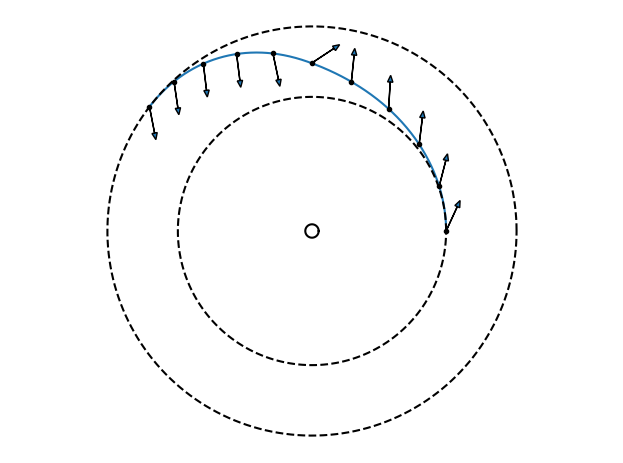

In [8]:
# convert thrust direction to inertial coordinates
v1 = np.cos(theta) * u1 - np.sin(theta) * u2
v2 = np.sin(theta) * u1 + np.cos(theta) * u2

# plot the trajectory
plt.plot(x, y)

# plot the inner and outer circular orbits, as well as the attracting center
alpha = np.linspace(0, 2 * np.pi, num=200)
plt.plot(r[0] * np.cos(alpha), r[0] * np.sin(alpha), "k--")
plt.plot(r[-1] * np.cos(alpha), r[-1] * np.sin(alpha), "k--")
plt.plot(0.05 * np.cos(alpha), 0.05 * np.sin(alpha), "k")

# plot the thrust direction at 11 locations
for i in range(11):
    j = round(i * (len(r) - 2) / 10)
    plt.plot(x[j], y[j], ".k")
    plt.arrow(
        x[j],
        y[j],
        0.25 * v1[j],
        0.25 * v2[j],
        length_includes_head=True,
        head_width=0.04,
        head_length=0.05,
    )

plt.axis("square")
plt.axis("equal")
plt.axis("off")
plt.tight_layout()

### State Histories

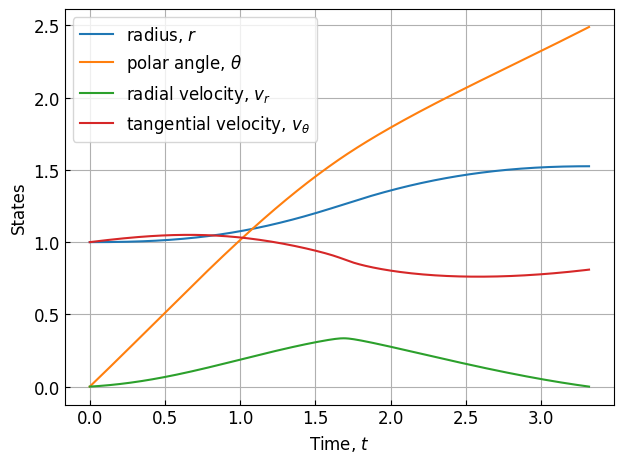

In [9]:
plt.plot(t, r, label=r"radius, $r$")
plt.plot(t, theta, label=r"polar angle, $\theta$")
plt.plot(t, v_r, label=r"radial velocity, $v_r$")
plt.plot(t, v_theta, label=r"tangential velocity, $v_\theta$")
plt.ylabel("States")
plt.xlabel("Time, $t$")
plt.grid()
plt.legend()
plt.tight_layout()

### Control Histories

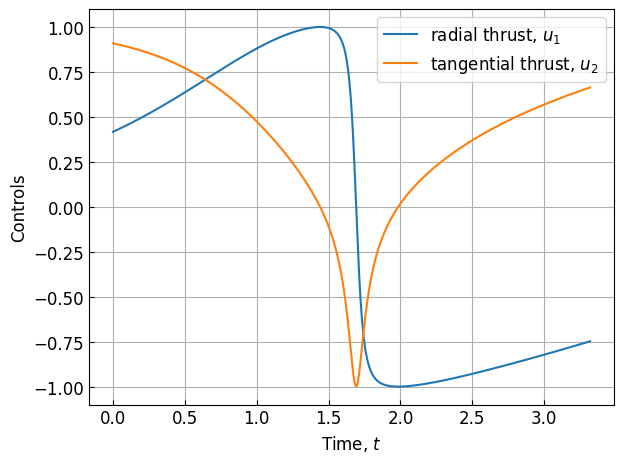

In [10]:
plt.plot(tc, control[0], label=r"radial thrust, $u_1$")
plt.plot(tc, control[1], label=r"tangential thrust, $u_2$")
plt.ylabel("Controls")
plt.xlabel("Time, $t$")
plt.grid()
plt.legend()
plt.tight_layout()

### Thrust Direction

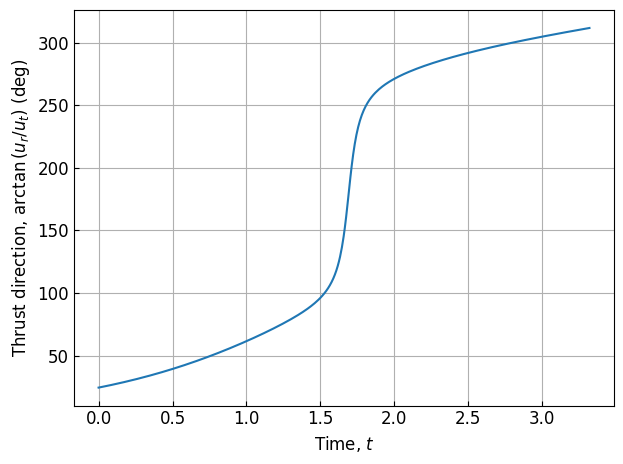

In [11]:
# Plot Thrust direction
plt.figure(4)
plt.plot(tc, 180 / pi * np.unwrap(np.arctan2(control[0], control[1])))
plt.xlabel("Time, $t$")
plt.ylabel(r"Thrust direction, $\arctan\left(u_r/u_t\right)$ (deg)")
plt.grid()
plt.tight_layout()

### Hamiltonian

Note that for this problem, the dynamics are not time-invariant, because the mass of the vehicle decreases with time. Therefore, the Hamiltonian is not constant.

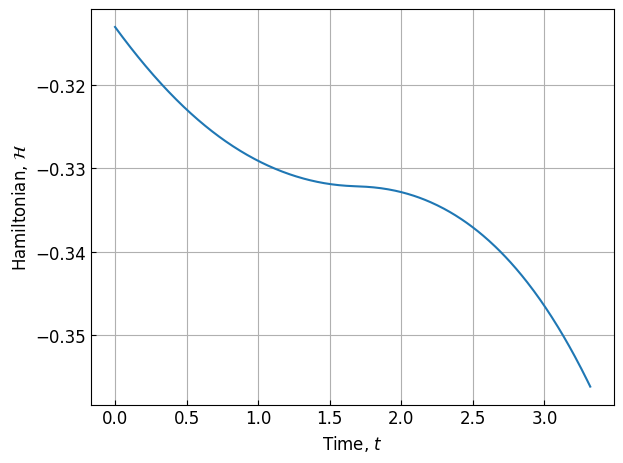

In [12]:
hamiltonian = solution.phase[0].hamiltonian
plt.plot(tc, hamiltonian / vt_0)
plt.ylabel(r"Hamiltonian, $\mathcal{H}$")
plt.xlabel("Time, $t$")
plt.grid()
plt.tight_layout()

## References